***Vorlesung 'Syntax natürlicher Sprachen', WS 2018/19***

---
# Übung 12

In [1]:
from exercises_12 import *
from questions import aufgabe
import nltk
from nltk.corpus import treebank
from nltk.grammar import ProbabilisticProduction, PCFG
from collections import defaultdict

---
## Aufgabe 1: Grammatikinduktion

#### In dieser Aufgabe soll vollautomatisch aus Daten (Syntaxbäumen) eine probabilistische, kontextfreie Grammatik erzeugt werden.

#### Füllen Sie die Lücken und versuchen Sie mithilfe Ihrer automatisch erstellten Grammatik die folgenden Sätze zu parsen:

In [2]:
test_sentences = [
    "the men saw a car .",
    "the woman gave the man a book .",
    "she gave a book to the man .",
    "yesterday , all my trouble seemed so far away ."
]

In [3]:
# Production count: the number of times a given production occurs
pcount = defaultdict(int)

# LHS-count: counts the number of times a given lhs occurs
lcount = defaultdict(int)

for tree in treebank.parsed_sents():
    for prod in tree.productions():
        pcount[prod] += 1
        lcount[prod.lhs()] += 1
        
productions = [
    ProbabilisticProduction(
        p.lhs(), p.rhs(),
        prob=pcount[p] / lcount[p.lhs()]
    )
    for p in pcount
]

start = nltk.Nonterminal('S')
grammar = PCFG(start, productions)
parser = nltk.ViterbiParser(grammar)

In [4]:
for s in test_sentences:
    for t in parser.parse(nltk.word_tokenize(s)):
        print(t.prob())
        t.pretty_print()

2.269940263066198e-15
                S                 
       _________|_______________   
      |             VP          | 
      |          ___|___        |  
    NP-SBJ      |       NP      | 
  ____|_____    |    ___|___    |  
 DT        NNS VBD  DT      NN  . 
 |          |   |   |       |   |  
the        men saw  a      car  . 

8.44395440336237e-21
                       S                             
       ________________|___________________________   
      |                        VP                  | 
      |            ____________|________           |  
    NP-SBJ        |        NP         NP-TMP       | 
  ____|______     |     ___|___     ____|_____     |  
 DT          NN  VBD   DT      NN  DT         NN   . 
 |           |    |    |       |   |          |    |  
the        woman gave the     man  a         book  . 

1.3157826588159793e-18
                     S                         
   __________________|_______________________   
  |                  VP   

---
## Aufgabe 2: Informationsextraktion per Syntaxanalyse

#### Gegenstand dieser Aufgabe ist eine anwendungsnahe Möglichkeit, Ergebnisse einer Syntaxanalyse weiterzuverarbeiten. Aus den syntaktischen Abhängigkeiten eines Textes soll (unter Zuhilfenahme einiger Normalisierungsschritte) eine semantische Repräsentation der im Text enthaltenen Informationen gewonnen werden.

#### Für die syntaktische Analyse soll der `DependencyParser` der Stanford CoreNLP Suite verwendet werden. Die semantische Repräsentation eines Satzes sei ein zweistelliges, logisches Prädikat, dessen Argumente durch Subjekt und Objekt gefüllt sind. (Bei Fehlen eines der beiden Elemente soll `None` geschrieben werden.)

#### Folgendes Beispiel illustriert das gewünschte Ergebnis:

#### Eingabe:

    I shot an elephant in my pajamas.
    The elephant was seen by a giraffe in the desert.
    The bird I need is a raven.
    The man who saw the raven laughed out loud.

#### Ausgabe:

    shot(I, elephant)
    seen(giraffe, elephant)
    need(I, bird)
    raven(bird, None)
    saw(man, raven)
    laughed(man, None)

#### Beachten Sie, dass `PATH_TO_CORE` in folgender Code-Zelle Ihrem System entsprechend angepasst werden muss!

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from nltk.parse.stanford import StanfordDependencyParser
import os

PATH_TO_CORE = os.path.join(os.getenv("HOME"), "nltk_data", "stanford-corenlp-full-2018-10-05")
jar = os.path.join(PATH_TO_CORE, "stanford-corenlp-3.9.2.jar")
model = os.path.join(PATH_TO_CORE,"stanford-corenlp-3.9.2-models.jar")

dep_parser = StanfordDependencyParser(
    jar, model,
    model_path="edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz"
)

In [7]:
def generate_predicates_for_sentence(sentence):
    predicates = defaultdict(lambda: [None, None])
    case_information = {}
    nmods = defaultdict(list)
    relcl_candidates = {}
    # prädikate -> [0, 1] -> wort
    for result in dep_parser.raw_parse(sentence):
        for triple in result.triples():
            if triple[1] == "nsubj" and not triple[2][1].startswith("W"):
                predicates[triple[0][0]][0] = triple[2][0]
                # triple[0][0]  # verb
                # triple[2][0]  # subjekt
            elif triple[1] == "dobj":
                predicates[triple[0][0]][1] = triple[2][0]
                # triple[0][0]  # verb
                # triple[2][0]  # dir. objekt
            elif triple[1] == "nsubjpass":
                predicates[triple[0][0]][1] = triple[2][0]
                # triple[0][0]  # verb
                # triple[2][0]  # subjekt
            elif triple[1] == "case":
                case_information[triple[0][0]] = triple[2][0]
            elif triple[1] == "nmod" and triple[0][1].startswith("V"):
                nmods[triple[0][0]].append(triple[2][0])
            elif triple[1] == "acl:relcl":
                # triple[0][0]  # z.B. ein Nomen
                # triple[2][0]  # verb
                relcl_candidates[triple[2][0]] = triple[0][0]
    
    # nominal modifiers that could be agents
    for pred, elements in predicates.items():
        if pred not in nmods:
            continue
        for nmod in nmods[pred]:
            if case_information[nmod] == "by" and elements[0] is None:
                elements[0] = nmod
    
    # relative clauses
    for pred, elements in predicates.items():
        if pred not in relcl_candidates:
            continue
        if elements[0] is None:
            elements[0] = relcl_candidates[pred]
        elif elements[1] is None:
            elements[1] = relcl_candidates[pred]

    return [
        "{}({}, {})".format(pred, elements[0], elements[1])
        for pred, elements in predicates.items()
    ]

In [8]:
for pred in generate_predicates_for_sentence(
    "The man who saw the raven laughed out loud."
):
    print(pred)

laughed(man, None)
saw(man, raven)


In [9]:
def generate_predicates_for_text(text):
    predicates = []
    for sent in nltk.tokenize.sent_tokenize(text):
        predicates.extend(generate_predicates_for_sentence(sent))
    return predicates

In [10]:
text = """
I shot an elephant in my pajamas.
The elephant was seen by a giraffe.
The bird I need is a raven.
The man who saw the raven laughed out loud.
"""

for pred in generate_predicates_for_text(text):
    print(pred)

shot(I, elephant)
seen(giraffe, elephant)
raven(bird, None)
need(I, bird)
laughed(man, None)
saw(man, raven)


--- 
# Hausaufgaben

---
## Aufgabe 3: Parent Annotation

#### *Parent Annotation* kann die Performanz einer CFG wesentlich verbessern. Schreiben Sie eine Funktion, die einen gegebenen Syntaxbaum dieser Optimierung unterzieht. Auf diese Art und Weise transformierte Bäume können dann wiederum zur Grammatikinduktion verwendet werden.

#### `parentHistory` soll dabei die Anzahl der Vorgänger sein, die zusätzlich zum direkten Elternknoten berücksichtigt werden. (Die Berücksichtigung dieses Parameters ist optional.)

#### `parentChar` soll ein Trennzeichen sein, das bei den neuen Knotenlabels zwischen dem ursprünglichen Knotenlabel und der Liste von Vorgängern eingefügt wird.

In [11]:
def parent_annotation(tree, parentHistory=0, parentChar="^"):
    def pa_rec(node, parents):
        originalNode = node.label() 
        parentString = (
            parentChar + '<' + '-'.join(parents) + '>'  
        )
        node.set_label(node.label() + parentString) 
        for child in node: 
            pa_rec(
                child,
                [originalNode] + parents[:parentHistory] 
            )
        return node
    return pa_rec(tree, []) 

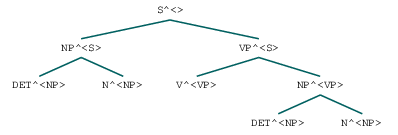

In [12]:
test_tree = nltk.Tree(
    "S",
    [
        nltk.Tree("NP", [
            nltk.Tree("DET", []),
            nltk.Tree("N", [])
        ]),
        nltk.Tree("VP", [
            nltk.Tree("V", []),
            nltk.Tree("NP", [
                nltk.Tree("DET", []),
                nltk.Tree("N", [])
            ])
        ])
    ]
)

parent_annotation(
   test_tree
)

---
## Aufgabe 4: Mehr Semantik für IE

#### Zusätzlich zu den in Aufgabe 2 behandelten Konstruktionen sollen jetzt auch negierte und komplexe Sätze mit Konjunktionen sinnvoll verarbeitet werden.

#### Eingabe:

    I see an elephant.
    You didn't see the elephant.
    Peter saw the elephant and drank wine.
    
#### Gewünschte Ausgabe:

    see(I, elephant)
    not_see(You, elephant)
    saw(Peter, elephant)
    drank(Peter, wine)
    
#### Kopieren Sie am besten Ihren aktuellen Stand von oben herunter und fügen Sie Ihre Erweiterungen dann hier ein.    

In [13]:
from collections import defaultdict
def generate_predicates_for_sentence(sentence):
    verbs = set()
    sbj = {}
    obj = {}
    sbj_candidates = defaultdict(list)
    case = {}
    negated = set()
    conj = {}

    rel_trip = []
    for result in dep_parser.raw_parse(sentence):
        for triple in result.triples():
            #print(*triple)
            if triple[1] == "nsubj":
                verbs.add(triple[0])
                sbj[triple[0]]=triple[2]
            if triple[1] == "dobj" or triple[1] == "nsubjpass":
                verbs.add(triple[0])
                obj[triple[0]]=triple[2] 
            if triple[0][1].startswith('V'):
                verbs.add(triple[0])
                if triple[1] == "nmod":
                    sbj_candidates[triple[0]].append(triple[2])
            if triple[1] == "case":
                case[triple[0]]=triple[2][0]
            if triple[1] == "acl:relcl":
                rel_trip.append(triple)   
            if triple[1] == "neg":
                negated.add(triple[0])
            if triple[1] == "conj":
                verbs.add(triple[0])
                verbs.add(triple[2])
                conj[triple[2]] = triple[0]
            
    for triple in rel_trip:
        if triple[2] not in sbj or sbj[triple[2]][1]=="WP":
            sbj[triple[2]] = triple[0]
        else:
            obj[triple[2]]= triple[0]
            
    for v in verbs:
        if v not in sbj and v in conj:
            sbj[v] = sbj[conj[v]]
        if v not in sbj:
            if v in sbj_candidates:
                for cand in sbj_candidates[v]:
                    if case[cand] == "by":
                        sbj[v]= cand
       
    predicates = []
    for v in verbs:
        if v in negated:
            verb = "not_" + v[0]
        else:
            verb = v[0]
        if v in sbj:
            subjekt = sbj[v]
        else:
            subjekt = ("None",)
        if v in obj:
            objekt = obj[v]
        else:
            objekt= ("None",)
        
        predicates.append(verb + "(" + subjekt[0] + ", " + objekt[0] + ")")
        
    return predicates

In [14]:
def generate_predicates_for_text(text):
    predicates = []
    for sent in nltk.tokenize.sent_tokenize(text):
        predicates.extend(generate_predicates_for_sentence(sent))
    return predicates

In [15]:
text = """
I see an elephant.
You didn't see the elephant.
Peter saw the elephant and drank wine.
"""

for pred in generate_predicates_for_text(text):
    print(pred)

see(I, elephant)
not_see(You, elephant)
drank(Peter, wine)
saw(Peter, elephant)


---
## Aufgabe 5: NLTK-Kapitel zu PCFGs

#### In folgenden NLTK-Kapiteln wird das Parsing mit Probabilistischen kontextfreien Grammatiken behandelt:
- Teilkapitel 8.6 (’Grammar Development’): http://www.nltk.org/book/ch08.html
- Teilkapitel 2.12 und 2.13 (’Grammar Induction’ und ’Normal Forms’) des Zusatzkapitels zu Kapitel 8: http://www.nltk.org/book/ch08-extras.html
- (Teilkapitel 2.9-2.11 des Zusatzkapitels zu Kapitel 8 behandelt Probabilistische ’Chart Parsing’-Algorithmen: http://www.nltk.org/book/ch08-extras.html)

#### Beantworten Sie folgende Fragen zu Teilkapitel 8.6.2 (’Pernicious Ambiguity’):

---
### Aufgabe 5 a:

#### Welche zwei Faktoren führen bei der syntaktischen Analyse natürlicher Sprache mittels formaler Grammatiken zu mehr Ambiguität (Anzahl an Ableitungen)?

In [16]:
aufgabe(blatt12_5a)

MultipleChoice(children=(HTML(value='<h4 style="font-size:14px;">Welche zwei Faktoren führen bei der syntaktis…

---
### Aufgabe 5 b:


In [17]:
aufgabe(blatt12_5b)

MultipleChoice(children=(HTML(value='<h4 style="font-size:14px;">Welche zwei Arten von Ambiguität unterscheide…